In [3]:
# !pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [5]:
# df.set_index("Datetime", inplace=True)

In [6]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


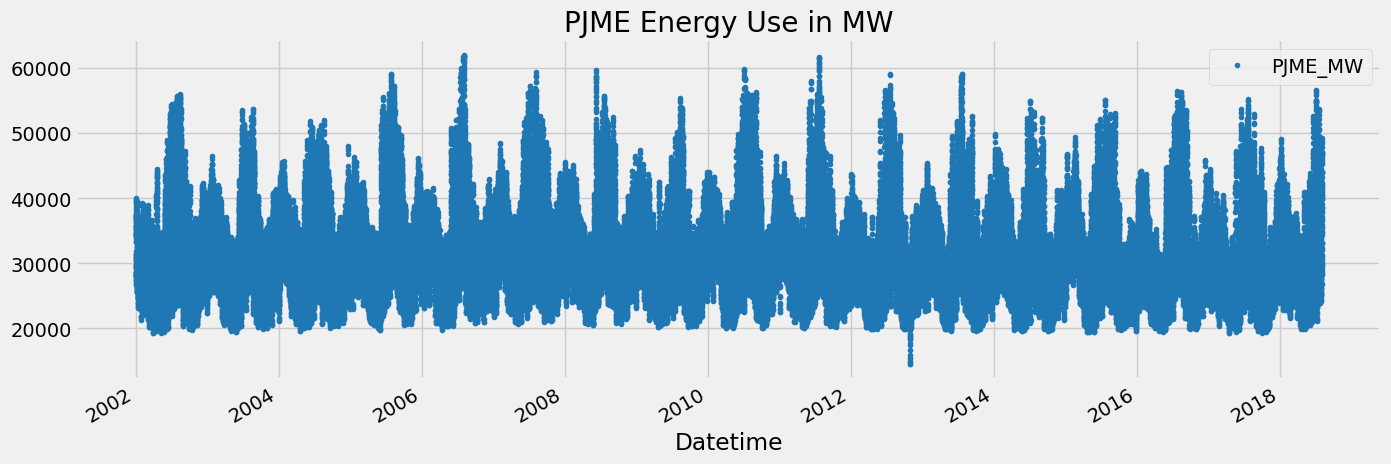

In [7]:
df.plot(style='.', figsize=(15, 5), color = color_pal[0], title='PJME Energy Use in MW')
plt.show()

In [8]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

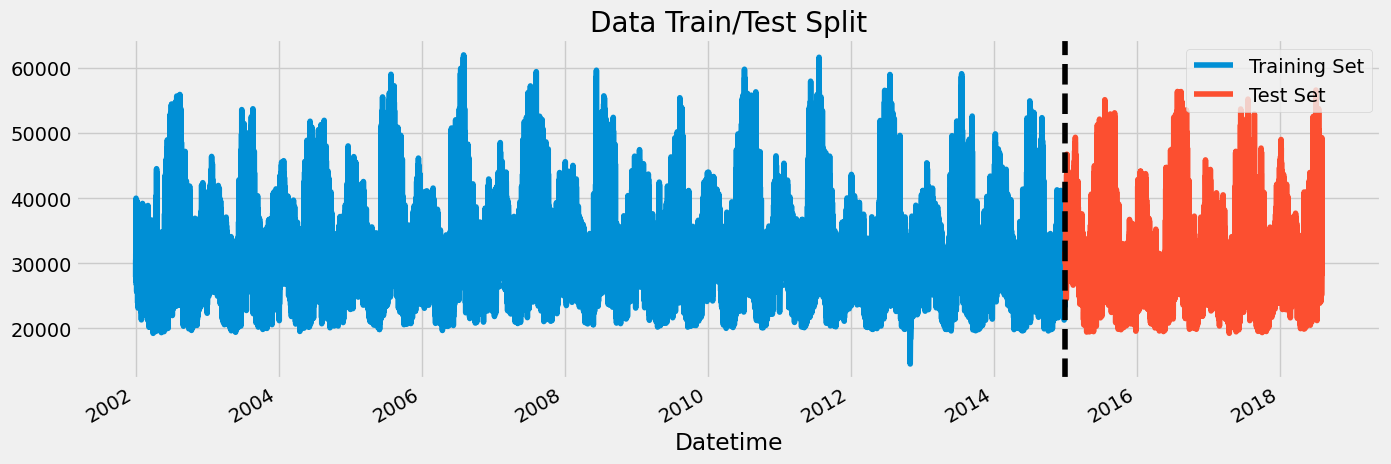

In [10]:
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

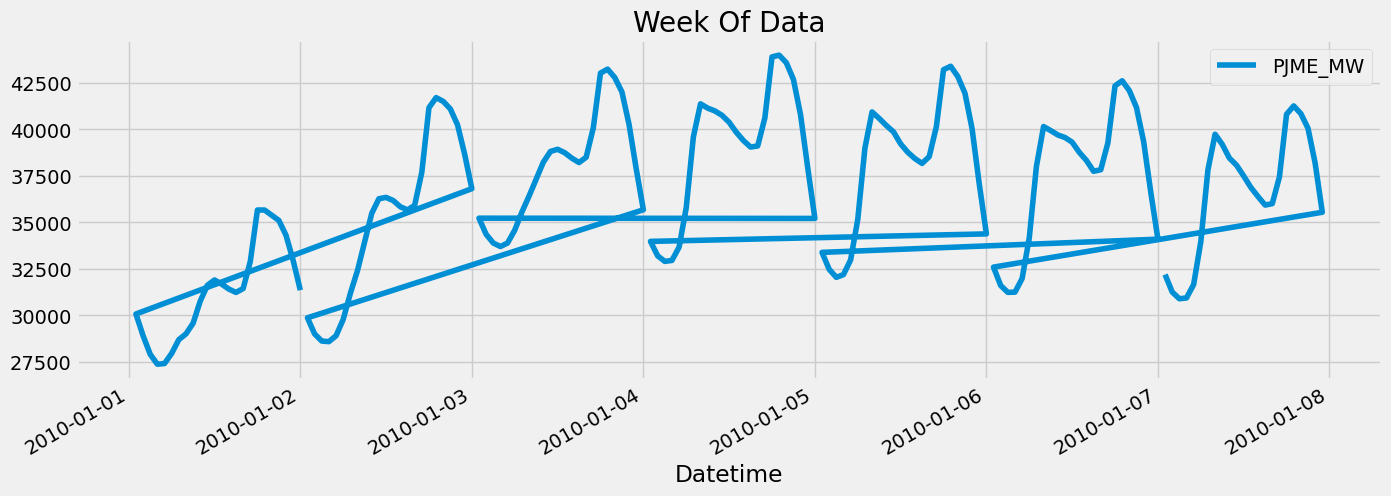

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [12]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [13]:
df = create_features(df)

In [14]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


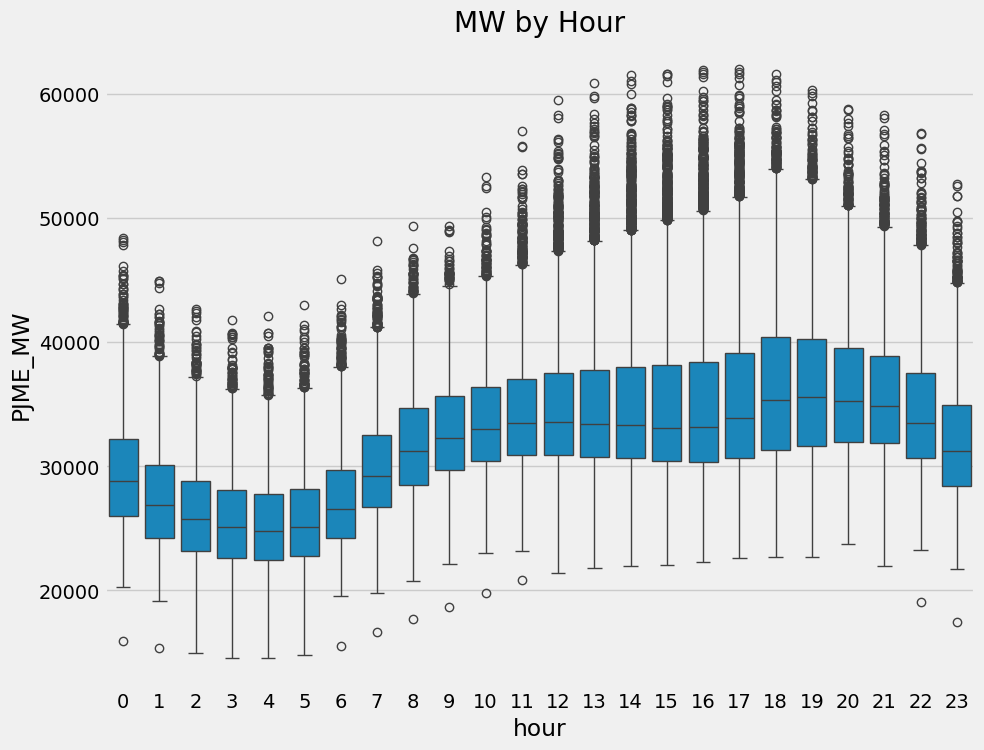

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

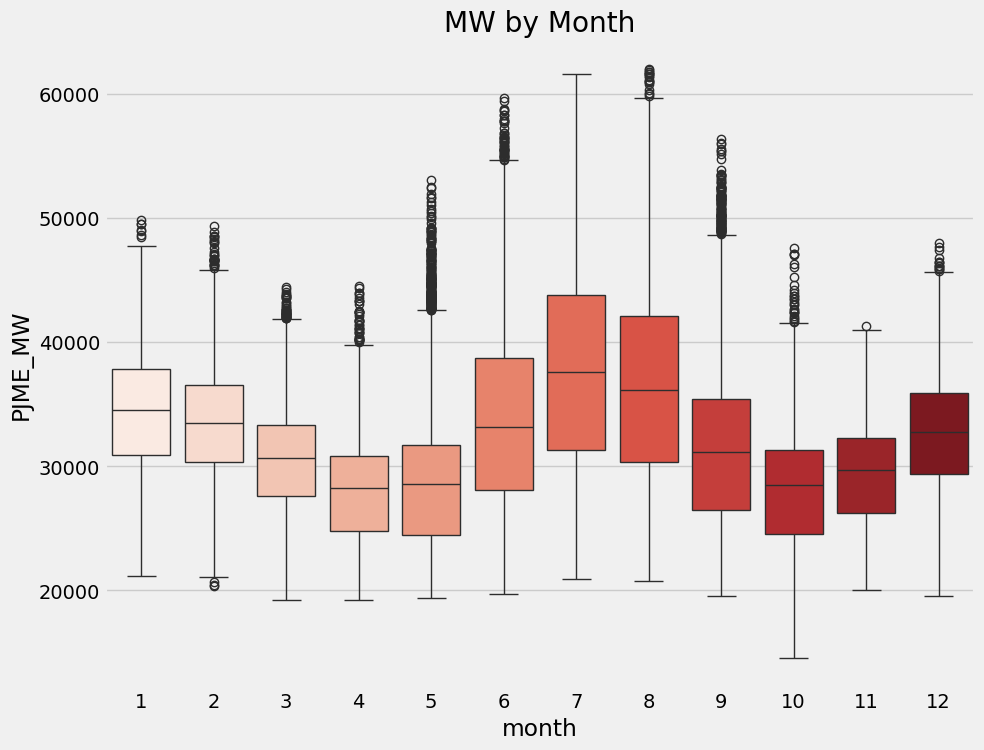

In [16]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Reds')
ax.set_title('MW by Month')
plt.show()

In [17]:
df_train = create_features(train)
df_test = create_features(test)

In [18]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [19]:
FEATURES = ['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [20]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [21]:
X_train = df_train.drop('PJME_MW', axis=1)
y_train = df_train['PJME_MW']

X_test = df_test.drop('PJME_MW', axis=1)
y_test = df_test['PJME_MW']

In [22]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stoppings_rounds = 50,
                      learning_rate=0.01)

In [23]:
reg.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[500]	validation_0-rmse:2696.13844	validation_1-rmse:3783.08999
[600]	validation_0-rmse:2591.46362	validation_1-rmse:3825.59526
[700]	validation_0-rmse:2510.88990	validation_1-rmse:3856.42145
[800]	validation_0-rmse:2453.43132	validation_1-rmse:3893.78376
[900]	validation_0-rmse:2412.70587	validation_1-rmse:3932.10447
[999]	validation_0-rmse:2377.89351	validation_1-rmse:3958.84396


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             early_stoppings_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [24]:
reg.feature_importances_

array([0.44760033, 0.11695988, 0.04130848, 0.23337609, 0.02923435,
       0.13152081], dtype=float32)

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

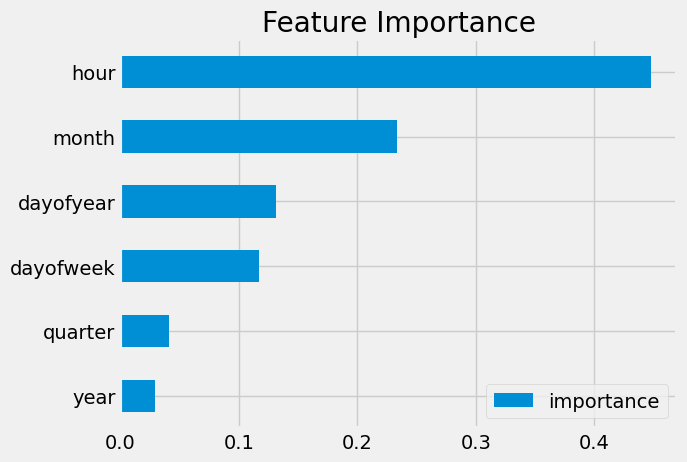

In [26]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')

In [27]:
df_test['prediction'] = reg.predict(X_test)

In [28]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

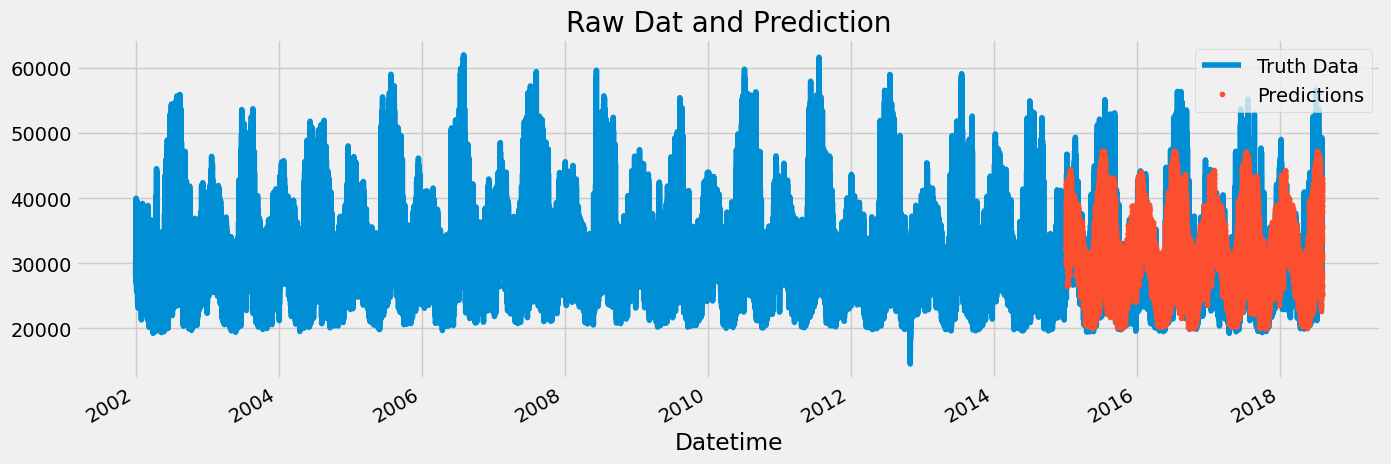

In [29]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

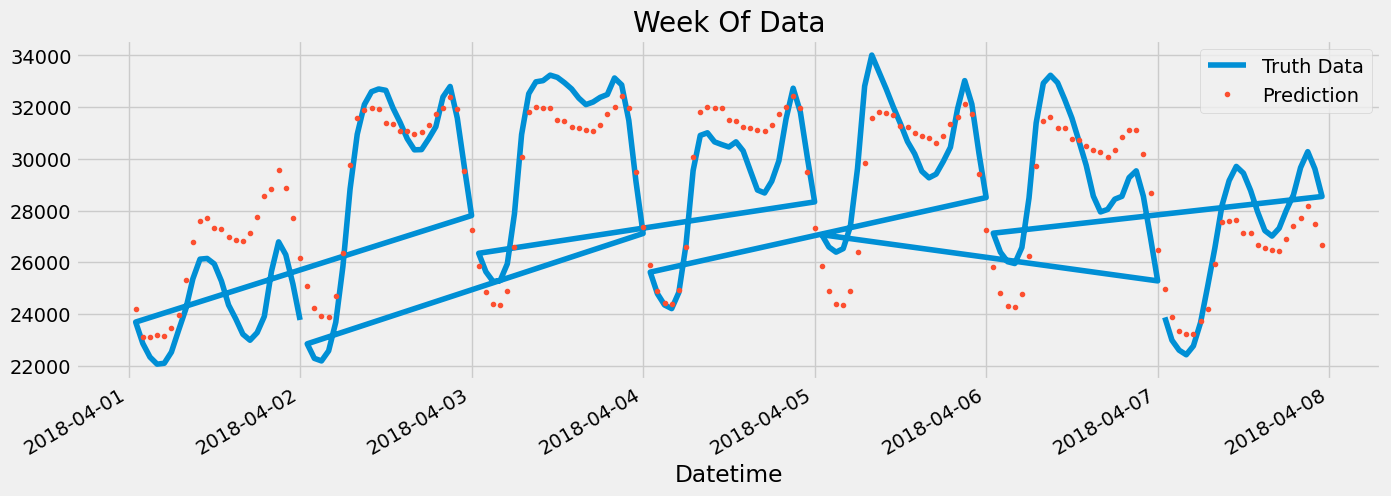

In [31]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [33]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE: {score:0.2f}')

RMSE Score on Test set: 3958.84


In [35]:
# Worst
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    16512.169678
2016-08-14    16438.347412
2016-08-12    12419.644613
2016-09-10    11107.929525
2016-09-09    10801.659017
2016-08-15    10654.005046
2017-05-19    10601.772461
2016-08-11    10441.915527
2015-02-20    10415.485840
2017-01-25    10329.219564
Name: error, dtype: float64

In [36]:
# Best
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-10-02    336.545573
2015-10-28    340.288330
2018-05-06    386.995687
2016-05-06    399.323324
2016-10-08    415.290853
2015-11-30    418.987061
2018-05-19    423.162272
2015-10-03    436.732015
2017-06-16    450.300618
2016-04-29    453.413086
Name: error, dtype: float64